<a href="https://colab.research.google.com/github/JordanByrd2380/bigquery_project/blob/main/big_query_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS145: Project 3 | Discovering Trends in NCAA Basketball History

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* Jordan Byrd, jbyrd23


## Project Overview

---

The main goal of this project is to predict whether a player will make a given shot based on a variety of factors such as the player's efficiency, height, weight, distance from the attacking basket, whether the shot is a clutch shot or not (we can define a clutch shot as < 15 seconds remaining in the half), and other general metrics such as assists, rebounds, and steals. Being able to accuractely predict these metrics can be useful in determining which team will win the game, and who should be taking the shots and where the shots should be taken from. 

---


## Analysis of Dataset

---

In this project, I am using the ncaa_basketball dataset found in the BigQuery public datasets. This dataset has a variety of tables, but for this project I am only using the mbb_pbp_sr and mbb_players_games_sr tables which are 3.14 GB and 421 MB, respectively. The mbb_pbp_sr table consists of play by play information such as shots, assists, steals, etc. In this project, I am only considering the field goal events from the table. The table also consists of seasons from the 2013-2014 season up until 2018. This table has an event_id primary key. The mbb_players_games_sr table consists of player statlines for every game over these same years. The primary key of this table is game_id, player_id pairs. In this project, I will be primarily focused on the mbb_pbp_sr table, but will perform joins with the mbb_players_games table on player_id in order to extract aggregated player information (assists, rebounds, steals, shooting percentages, height, weight). 

----

## Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "project1-327322"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

---

One very useful feature to start with is calculating the distance between the shot that was taken and the basket which the player is attacking. This will aid in determining the odds of whether the shot was made. More useful information might be information such as the physical build of the player who took the shot, such as height, weight, and overall athleticism. This information can be found by joining the pbp table with the mbb_players on player_id. 

*TODO: Exploring your questions, with appropriate visualizations*

---

Here, we can see whether a shot was made based on how far away the shot was taken from:

In [ ]:
%%bigquery --project $project_id q1

SELECT IF(team_basket = "left", SQRT(POWER(event_coord_x, 2) + POWER(event_coord_y - 300, 2)), SQRT(POWER(event_coord_x - 1128, 2) + POWER(event_coord_y - 300, 2))) AS distance,
IF(shot_made = false, 0, 1) label
FROM `bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
LIMIT 100000

Text(0, 0.5, 'Shot Made')

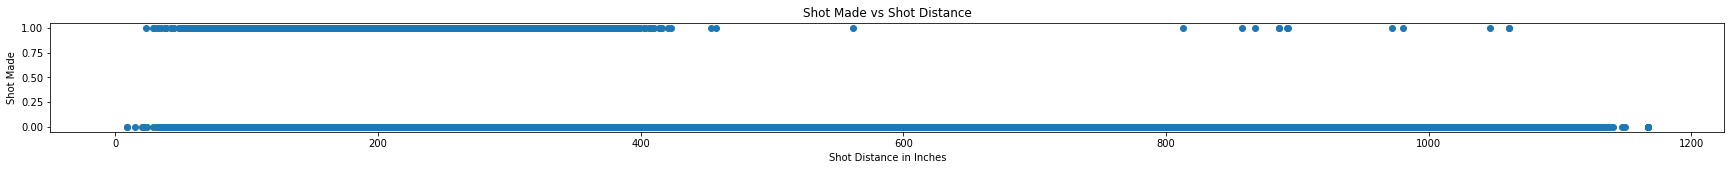

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 2))
plt.scatter(q1["distance"], q1["label"])
plt.title("Shot Made vs Shot Distance")
plt.xlabel("Shot Distance in Inches")
plt.ylabel("Shot Made")

As we can see, the majority of shots are made from within 400 inches of the basket. Given a new data point with a distance of over 400 inches would be almost certainly 0.

Another useful feature we can get is the player's efficiency and aggregate statistics. This can help us predict whether the player is likely to make the shot or not. 

In [ ]:
%%bigquery --project $project_id q2

SELECT DISTINCT pct, IF(shot_made = false, 0, 1) label
FROM ( SELECT player_id, SUM(free_throws_made)/SUM(free_throws_att) + SUM(two_points_made)/SUM(two_points_att) + SUM(three_points_made)/SUM(three_points_att) pct
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr` 
WHERE free_throws_att != 0
AND two_points_att != 0
AND three_points_att != 0
GROUP BY player_id) t1, 
`bigquery-public-data.ncaa_basketball.mbb_pbp_sr` t2
WHERE t1.player_id = t2.player_id
LIMIT 30

Text(0, 0.5, 'Shot Made')

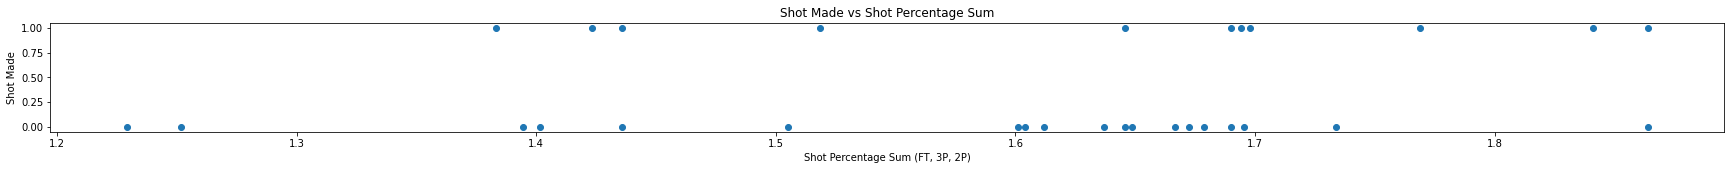

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 2))
plt.scatter(q2["pct"], q2["label"])
plt.title("Shot Made vs Shot Percentage Sum")
plt.xlabel("Shot Percentage Sum (FT, 3P, 2P)")
plt.ylabel("Shot Made")

From this chosen sample, we can see that players who shoot higher percentages tend to make more shots. From this sample, no players even had a total shooting percentage over 2.0, which demonstrates why most of the shots were missd. 

It may also be helpful to opt to include other aggregate features, such as assists, steals, and rebounds. While these stats may not seem to directly help us know how good a shooter is, they are positively correlated to how good a player generally is. Therefore, higher stats might tell us a player is more likely to produce. 

Another useful stat is how much time is remaining in the half. This is because as there is less time in the half, the player has to get a shot off. Intuitively, when there is very little time remaining in the half when a player shoots the ball, we can expect the player to likely miss the shot. This is because the player is likely forced to get a shot up, and it may not be ideal. Since this is only really applicable when there is very little time remaning in the half, we can create a boolean where it is activated only when there is less than 15 seconds remaining in the half.

In [ ]:
%%bigquery --project $project_id q3
SELECT IF(shot_made = false, 0, 1) label, IF(IF(elapsed_time_sec > 1200, 2400 - elapsed_time_sec, 1200 - elapsed_time_sec) > 15, 0, 1) clutch_shot
FROM `bigquery-public-data.ncaa_basketball.mbb_pbp_sr` LIMIT 100000

0.18408144671744728 0.11967183877296236


Text(0.5, 1.0, 'Shot Percentage vs. Whether Shot was Clutch')

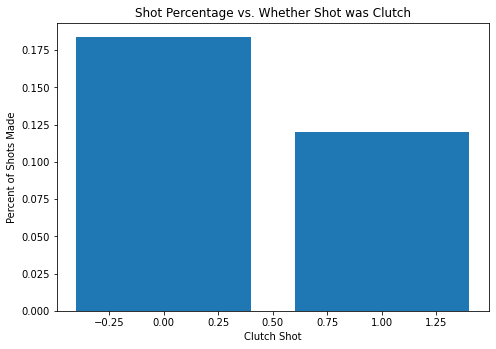

In [ ]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(30, 2))
total_nonclutch = 0
total0 = 0
total_clutch = 0
total1 = 0
for i in range(len(q3['clutch_shot'])):
  if q3['clutch_shot'][i] == 1:
    total1 += q3['label'][i]
    total_clutch += 1
  else:
    total0 += q3['label'][i]
    total_nonclutch += 1
print(total0/total_nonclutch, total1/total_clutch)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([0, 1], [total0/total_nonclutch, total1/total_clutch])
ax.set_ylabel("Percent of Shots Made")
ax.set_xlabel("Clutch Shot")
ax.set_title("Shot Percentage vs. Whether Shot was Clutch")

We can see that there is a noticeable difference between the shot percentages, which makes this a useful feature.  

One last thing we can do is see if there is some correlation between size (height and weight) and whether a shot is made. 

In [ ]:
%%bigquery --project $project_id q4

SELECT height,
(SUM(free_throws_made) + SUM(two_points_made) + SUM(three_points_made))/(SUM(free_throws_att) + SUM(two_points_att) + SUM(three_points_att)) pct 
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
GROUP BY height
HAVING (SUM(free_throws_att) + SUM(two_points_att) + SUM(three_points_att)) != 0
#LIMIT 1000

(55.0, 100.0)

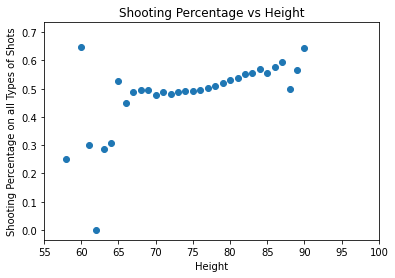

In [ ]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(30, 2))
plt.scatter(q4["height"], q4["pct"])
plt.title("Shooting Percentage vs Height")
plt.xlabel("Height")
plt.ylabel("Shooting Percentage on all Types of Shots")
plt.xlim([55, 100])

In [ ]:
%%bigquery --project $project_id q5

SELECT weight,
(SUM(free_throws_made) + SUM(two_points_made) + SUM(three_points_made))/(SUM(free_throws_att) + SUM(two_points_att) + SUM(three_points_att)) pct 
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
GROUP BY weight
HAVING (SUM(free_throws_att) + SUM(two_points_att) + SUM(three_points_att)) != 0

(120.0, 375.0)

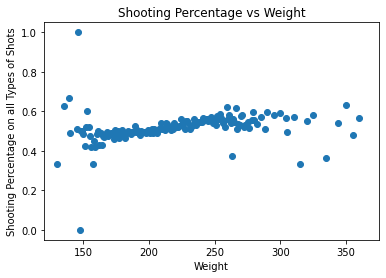

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(q5["weight"], q5["pct"])
plt.title("Shooting Percentage vs Weight")
plt.xlabel("Weight")
plt.ylabel("Shooting Percentage on all Types of Shots")
plt.xlim([120, 375])

From this, we can see that there seems to be some correlation between height, weight, and shooting percentage. For height, taller players tend to have better shooting splits. With weight, there seems to be a positive trend in shooting percentage with weight, unless the player reaches over 300 pounds. There are some outliers, but this is only in regions where there is likely only one player of a certain height or weight, and thus, it is more likely for the shooting splits to be closer to 0 or 1 (in the case of very few shots taken). 

## Data Prediction

---
We can use the above features to train with, plus some other useful features that are more trivial to use. We can form the problem as a logistic regression problem that attempts to determine whether the player will make or miss the shot based on the provided features. The training set will be the data from the 2013-2014 season until 2016. The validation set will be data from 2017, and the test set will be data from 2018. 

---

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'ncaa_basketball'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('project1-327322', 'ncaa_basketball'))

In [ ]:
%%bigquery --project $project_id

# YOUR QUERY HERE

CREATE OR REPLACE MODEL `ncaa_basketball.basketball_model` 
OPTIONS(model_type = 'logistic_reg') AS
SELECT label, distance, clutch_shot, shot_type, three_point_shot, w, h, ft, two, three, r, a, s 
FROM 

(SELECT IF(team_basket = "left", SQRT(POWER(event_coord_x, 2) + POWER(event_coord_y - 300, 2)), SQRT(POWER(event_coord_x - 1128, 2) + POWER(event_coord_y - 300, 2))) distance,
IF(shot_made = false, 0, 1) label, IF(IF(elapsed_time_sec > 1200, 2400 - elapsed_time_sec, 1200 - elapsed_time_sec) > 15, 0, 1) clutch_shot,
shot_type, three_point_shot, player_id FROM 
`bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
WHERE EXTRACT(YEAR FROM scheduled_date) <= 2016
AND type='fieldgoal'
) t1,

(SELECT AVG(weight) w, AVG(height) h, SUM(free_throws_made)/SUM(free_throws_att) ft, 
SUM(two_points_made)/SUM(two_points_att) two,
SUM(three_points_made)/SUM(three_points_att) three, 
AVG(rebounds) r, AVG(assists) a, AVG(steals) s, player_id
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
GROUP BY player_id
HAVING SUM(free_throws_att) != 0
AND SUM(two_points_att) != 0
AND SUM(three_points_att) != 0
) t2

WHERE t1.player_id = t2.player_id




""


In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `ncaa_basketball.basketball_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,3,0.654673,0.654735,1.6,19822
1,0,2,0.660715,0.660529,0.8,21495
2,0,1,0.672246,0.672080,0.4,18987
3,0,0,0.684375,0.684300,0.2,15375


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `ncaa_basketball.basketball_model`, (
    SELECT label, distance, clutch_shot, shot_type, three_point_shot, w, h, ft, two, three, r, a, s 
FROM 

(SELECT IF(team_basket = "left", SQRT(POWER(event_coord_x, 2) + POWER(event_coord_y - 300, 2)), SQRT(POWER(event_coord_x - 1128, 2) + POWER(event_coord_y - 300, 2))) distance,
IF(shot_made = false, 0, 1) label, IF(IF(elapsed_time_sec > 1200, 2400 - elapsed_time_sec, 1200 - elapsed_time_sec) > 15, 0, 1) clutch_shot,
shot_type, three_point_shot, player_id FROM 
`bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
WHERE EXTRACT(YEAR FROM scheduled_date) = 2017
AND type='fieldgoal'
) t1,

(SELECT AVG(weight) w, AVG(height) h, SUM(free_throws_made)/SUM(free_throws_att) ft, 
SUM(two_points_made)/SUM(two_points_att) two,
SUM(three_points_made)/SUM(three_points_att) three, 
AVG(rebounds) r, AVG(assists) a, AVG(steals) s, player_id
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
GROUP BY player_id
HAVING SUM(free_throws_att) != 0
AND SUM(two_points_att) != 0
AND SUM(three_points_att) != 0
) t2

WHERE t1.player_id = t2.player_id
) )

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.607162,0.432309,0.629446,0.505029,0.654579,0.630357


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `ncaa_basketball.basketball_model`, (
   SELECT label, distance, clutch_shot, shot_type, three_point_shot, w, h, ft, two, three, r, a, s 
FROM 

(SELECT IF(team_basket = "left", SQRT(POWER(event_coord_x, 2) + POWER(event_coord_y - 300, 2)), SQRT(POWER(event_coord_x - 1128, 2) + POWER(event_coord_y - 300, 2))) distance,
IF(shot_made = false, 0, 1) label, IF(IF(elapsed_time_sec > 1200, 2400 - elapsed_time_sec, 1200 - elapsed_time_sec) > 15, 0, 1) clutch_shot,
shot_type, three_point_shot, player_id FROM 
`bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
WHERE EXTRACT(YEAR FROM scheduled_date) = 2018
AND type='fieldgoal'
) t1,

(SELECT AVG(weight) w, AVG(height) h, SUM(free_throws_made)/SUM(free_throws_att) ft, 
SUM(two_points_made)/SUM(two_points_att) two,
SUM(three_points_made)/SUM(three_points_att) three, 
AVG(rebounds) r, AVG(assists) a, AVG(steals) s, player_id
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
GROUP BY player_id
HAVING SUM(free_throws_att) != 0
AND SUM(two_points_att) != 0
AND SUM(three_points_att) != 0
) t2

WHERE t1.player_id = t2.player_id
) )

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.601252,0.432087,0.625823,0.502823,0.655326,0.628883


In [ ]:
%%bigquery --project $project_id

SELECT
*
FROM
  ML.PREDICT(MODEL `ncaa_basketball.basketball_model`, (
   SELECT label, distance, clutch_shot, shot_type, three_point_shot, w, h, ft, two, three, r, a, s 
FROM 

(SELECT IF(team_basket = "left", SQRT(POWER(event_coord_x, 2) + POWER(event_coord_y - 300, 2)), SQRT(POWER(event_coord_x - 1128, 2) + POWER(event_coord_y - 300, 2))) distance,
IF(shot_made = false, 0, 1) label, IF(IF(elapsed_time_sec > 1200, 2400 - elapsed_time_sec, 1200 - elapsed_time_sec) > 15, 0, 1) clutch_shot,
shot_type, three_point_shot, player_id FROM 
`bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
WHERE EXTRACT(YEAR FROM scheduled_date) = 2018
AND type='fieldgoal'
) t1,

(SELECT AVG(weight) w, AVG(height) h, SUM(free_throws_made)/SUM(free_throws_att) ft, 
SUM(two_points_made)/SUM(two_points_att) two,
SUM(three_points_made)/SUM(three_points_att) three, 
AVG(rebounds) r, AVG(assists) a, AVG(steals) s, player_id
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
GROUP BY player_id
HAVING SUM(free_throws_att) != 0
AND SUM(two_points_att) != 0
AND SUM(three_points_att) != 0
) t2

WHERE t1.player_id = t2.player_id
))

,predicted_label,predicted_label_probs,label,distance,clutch_shot,shot_type,three_point_shot,w,h,ft,two,three,r,a,s
0,1,"[{'label': 1, 'prob': 0.5094775311283893}, {'l...",0,171.093542,0,hook shot,False,233.0,86.0,0.512821,0.621495,0.000000,1.990099,0.079208,0.089109
1,1,"[{'label': 1, 'prob': 0.5082500843309192}, {'l...",0,174.427635,0,hook shot,False,233.0,86.0,0.512821,0.621495,0.000000,1.990099,0.079208,0.089109
2,0,"[{'label': 1, 'prob': 0.4709162033159695}, {'l...",1,110.113578,0,jump shot,False,233.0,86.0,0.512821,0.621495,0.000000,1.990099,0.079208,0.089109
3,1,"[{'label': 1, 'prob': 0.5472972586744731}, {'l...",0,68.014704,0,hook shot,False,233.0,86.0,0.512821,0.621495,0.000000,1.990099,0.079208,0.089109
4,1,"[{'label': 1, 'prob': 0.501570764562482}, {'la...",0,192.566872,0,hook shot,False,233.0,86.0,0.512821,0.621495,0.000000,1.990099,0.079208,0.089109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149208,1,"[{'label': 1, 'prob': 0.5067997088625192}, {'l...",1,127.577427,0,hook shot,False,230.0,83.0,0.388060,0.564516,0.214286,1.655738,0.262295,0.131148
149209,1,"[{'label': 1, 'prob': 0.544709048167753}, {'la...",1,97.082439,0,layup,False,230.0,83.0,0.388060,0.564516,0.214286,1.655738,0.262295,0.131148
149210,0,"[{'label': 1, 'prob': 0.4839052168027021}, {'l...",0,118.848643,0,hook shot,False,245.0,83.0,0.453333,0.483146,0.090909,1.120482,0.216867,0.073171
149211,0,"[{'label': 1, 'prob': 0.34439135167088303}, {'...",1,335.037311,0,jump shot,True,228.0,83.0,0.505495,0.564815,0.324324,2.312500,0.162500,0.150000


In order to determine which metric is most important, we can see the ratios of each class:


In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*) FROM `bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
WHERE type = "fieldgoal"
AND shot_made = true

,f0_
0,554615


In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*) FROM `bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
WHERE type = "fieldgoal"
AND shot_made = false

,f0_
0,717356


We can see that the classes are roughly balanced, so accuracy is the best metric to use. The accuracy was about 63%, which is not ideal, but still a better predictor than predicting without information. 

## Conclusion

---

The selected features above tend to demonstrate the quality of a particular player. However, as we know from basketball in real life, even the best players often miss shots they are expected to make, and it is often impossible to know why the player missed the shot. Most players' field goal percentages tend to hover around 40%-50% in the long run, even from midrange. However, it is often easy to predict with high probability whether a shot will go in if it is either very close to the attacking basket or very far away from the attacking basket. This fact likely boosted the model's performance. We can put this theory to the test:

---

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `ncaa_basketball.basketball_model`, (
   SELECT label, distance, clutch_shot, shot_type, three_point_shot, w, h, ft, two, three, r, a, s 
FROM 

(SELECT IF(team_basket = "left", SQRT(POWER(event_coord_x, 2) + POWER(event_coord_y - 300, 2)), SQRT(POWER(event_coord_x - 1128, 2) + POWER(event_coord_y - 300, 2))) distance,
IF(shot_made = false, 0, 1) label, IF(IF(elapsed_time_sec > 1200, 2400 - elapsed_time_sec, 1200 - elapsed_time_sec) > 15, 0, 1) clutch_shot,
shot_type, three_point_shot, player_id FROM 
`bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
WHERE EXTRACT(YEAR FROM scheduled_date) = 2018
AND type='fieldgoal'
) t1,

(SELECT AVG(weight) w, AVG(height) h, SUM(free_throws_made)/SUM(free_throws_att) ft, 
SUM(two_points_made)/SUM(two_points_att) two,
SUM(three_points_made)/SUM(three_points_att) three, 
AVG(rebounds) r, AVG(assists) a, AVG(steals) s, player_id
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
GROUP BY player_id
HAVING SUM(free_throws_att) != 0
AND SUM(two_points_att) != 0
AND SUM(three_points_att) != 0
) t2

WHERE t1.player_id = t2.player_id
AND distance > 400
) )

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.0,0.0,0.73872,0.0,0.562869,0.611943


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `ncaa_basketball.basketball_model`, (
   SELECT label, distance, clutch_shot, shot_type, three_point_shot, w, h, ft, two, three, r, a, s 
FROM 

(SELECT IF(team_basket = "left", SQRT(POWER(event_coord_x, 2) + POWER(event_coord_y - 300, 2)), SQRT(POWER(event_coord_x - 1128, 2) + POWER(event_coord_y - 300, 2))) distance,
IF(shot_made = false, 0, 1) label, IF(IF(elapsed_time_sec > 1200, 2400 - elapsed_time_sec, 1200 - elapsed_time_sec) > 15, 0, 1) clutch_shot,
shot_type, three_point_shot, player_id FROM 
`bigquery-public-data.ncaa_basketball.mbb_pbp_sr` 
WHERE EXTRACT(YEAR FROM scheduled_date) = 2018
AND type='fieldgoal'
) t1,

(SELECT AVG(weight) w, AVG(height) h, SUM(free_throws_made)/SUM(free_throws_att) ft, 
SUM(two_points_made)/SUM(two_points_att) two,
SUM(three_points_made)/SUM(three_points_att) three, 
AVG(rebounds) r, AVG(assists) a, AVG(steals) s, player_id
FROM `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
GROUP BY player_id
HAVING SUM(free_throws_att) != 0
AND SUM(two_points_att) != 0
AND SUM(three_points_att) != 0
) t2

WHERE t1.player_id = t2.player_id
AND distance < 75
) )

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.719499,0.943347,0.702585,0.816356,0.616178,0.643083


As we can see, the accuracy was boosted by about 10% in both cases, as expected.